In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

df = pd.read_csv('./weather.csv')


c:\Users\navid-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\851579208.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


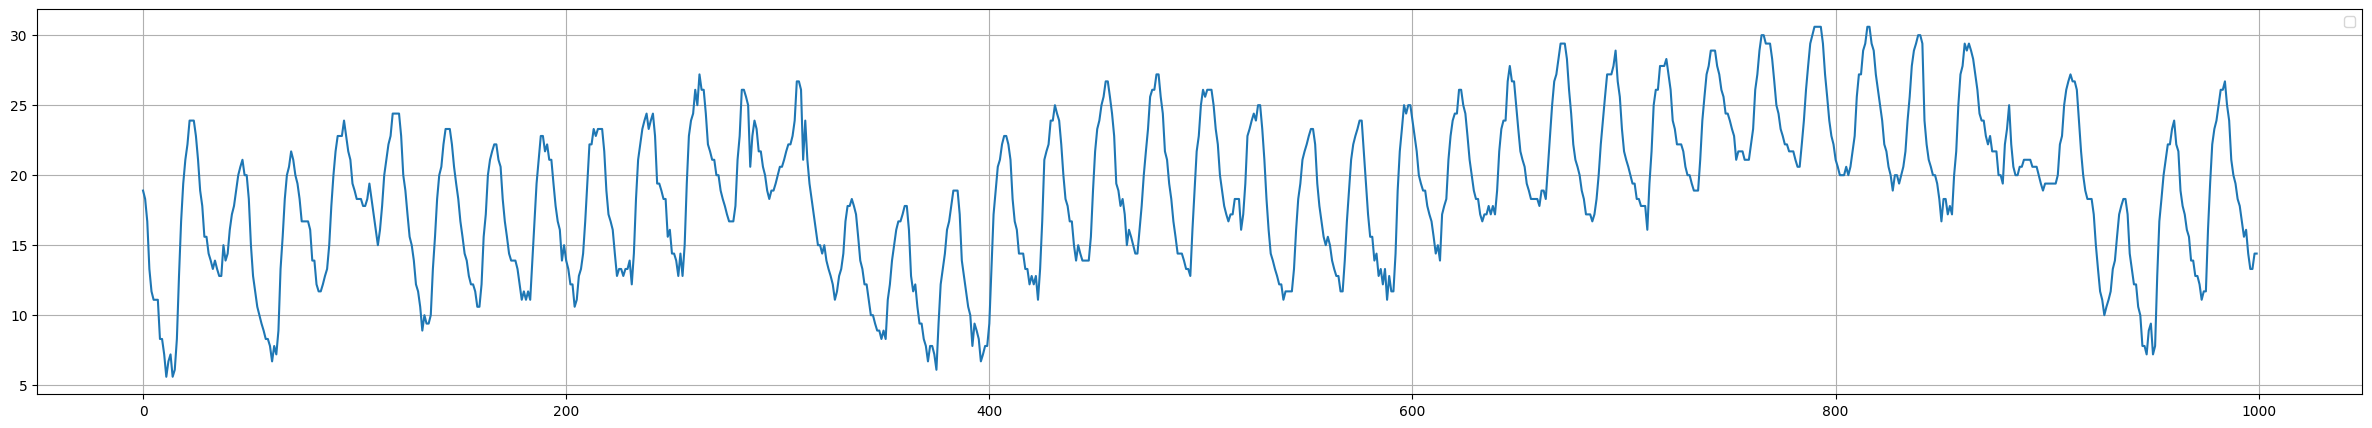

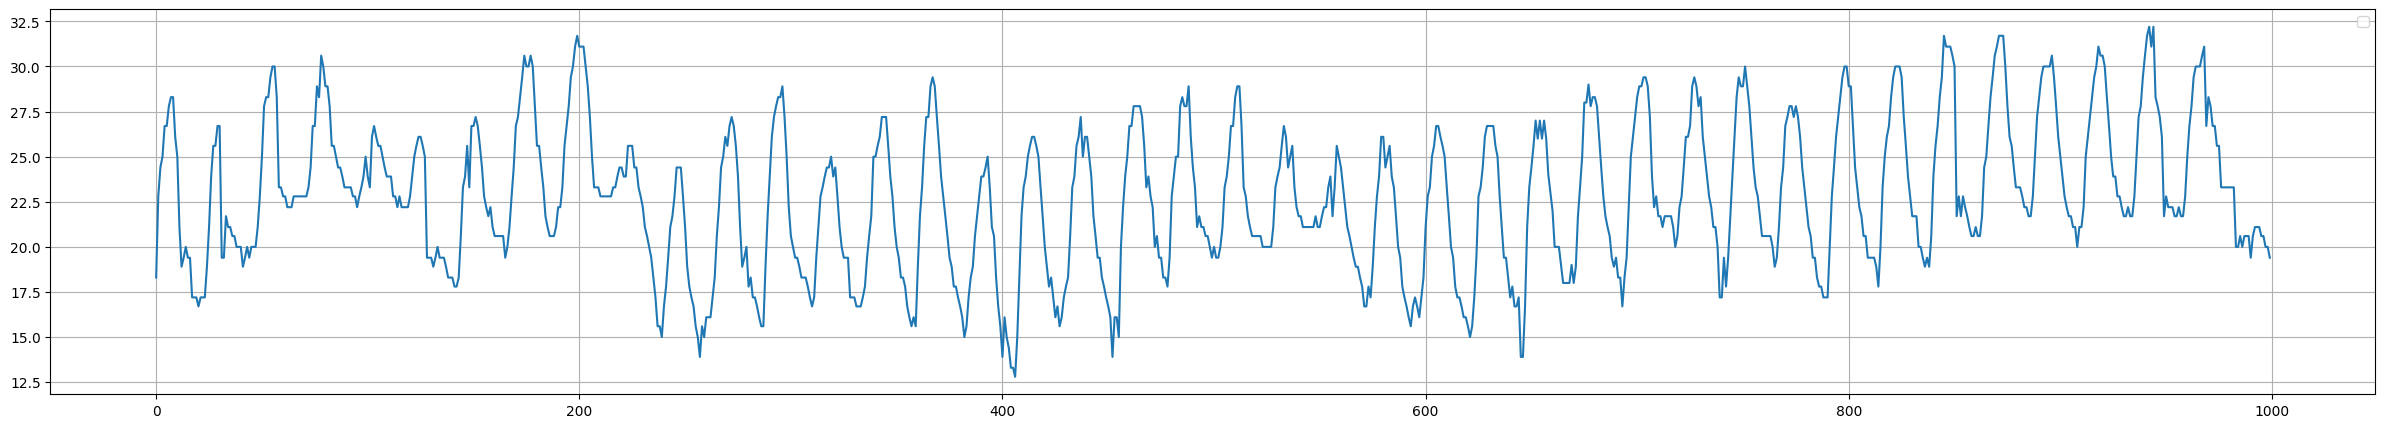

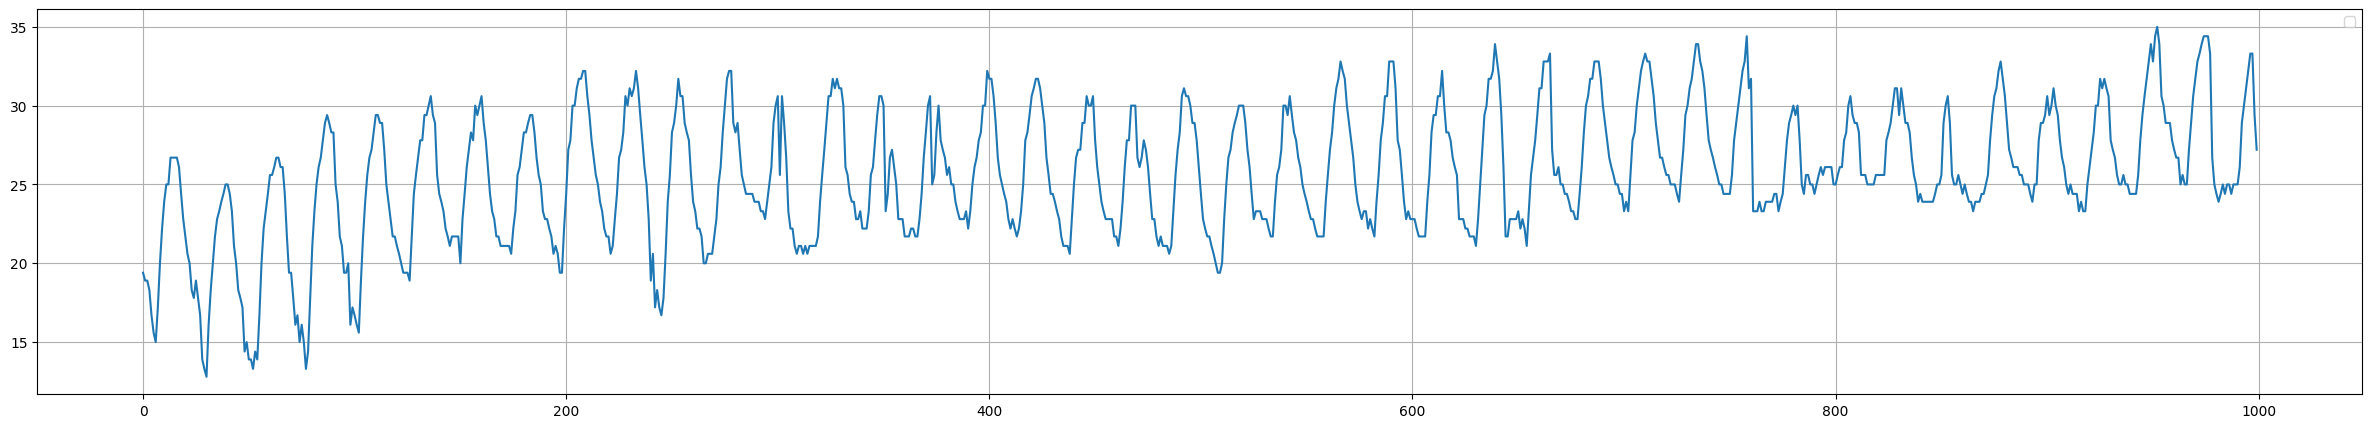

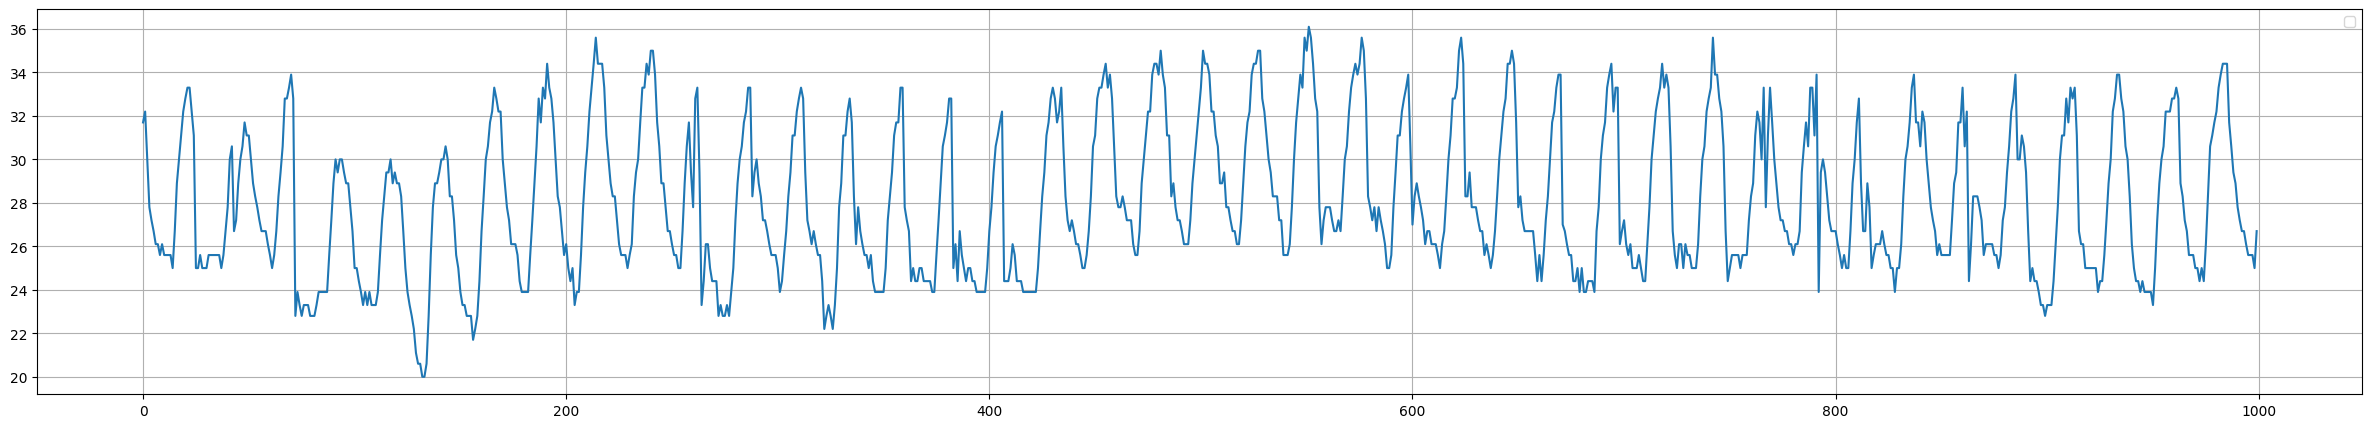

In [2]:
data =  df['airTemperature'].values

# plot the data
for i in range(1000, 5000, 1000):
    plt.figure(figsize=(30, 5))
    plt.plot(data[i:i+1000])
    plt.legend()
    plt.grid()
    plt.show()


# Chronos model

In [51]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  
    torch_dtype=torch.bfloat16,
)

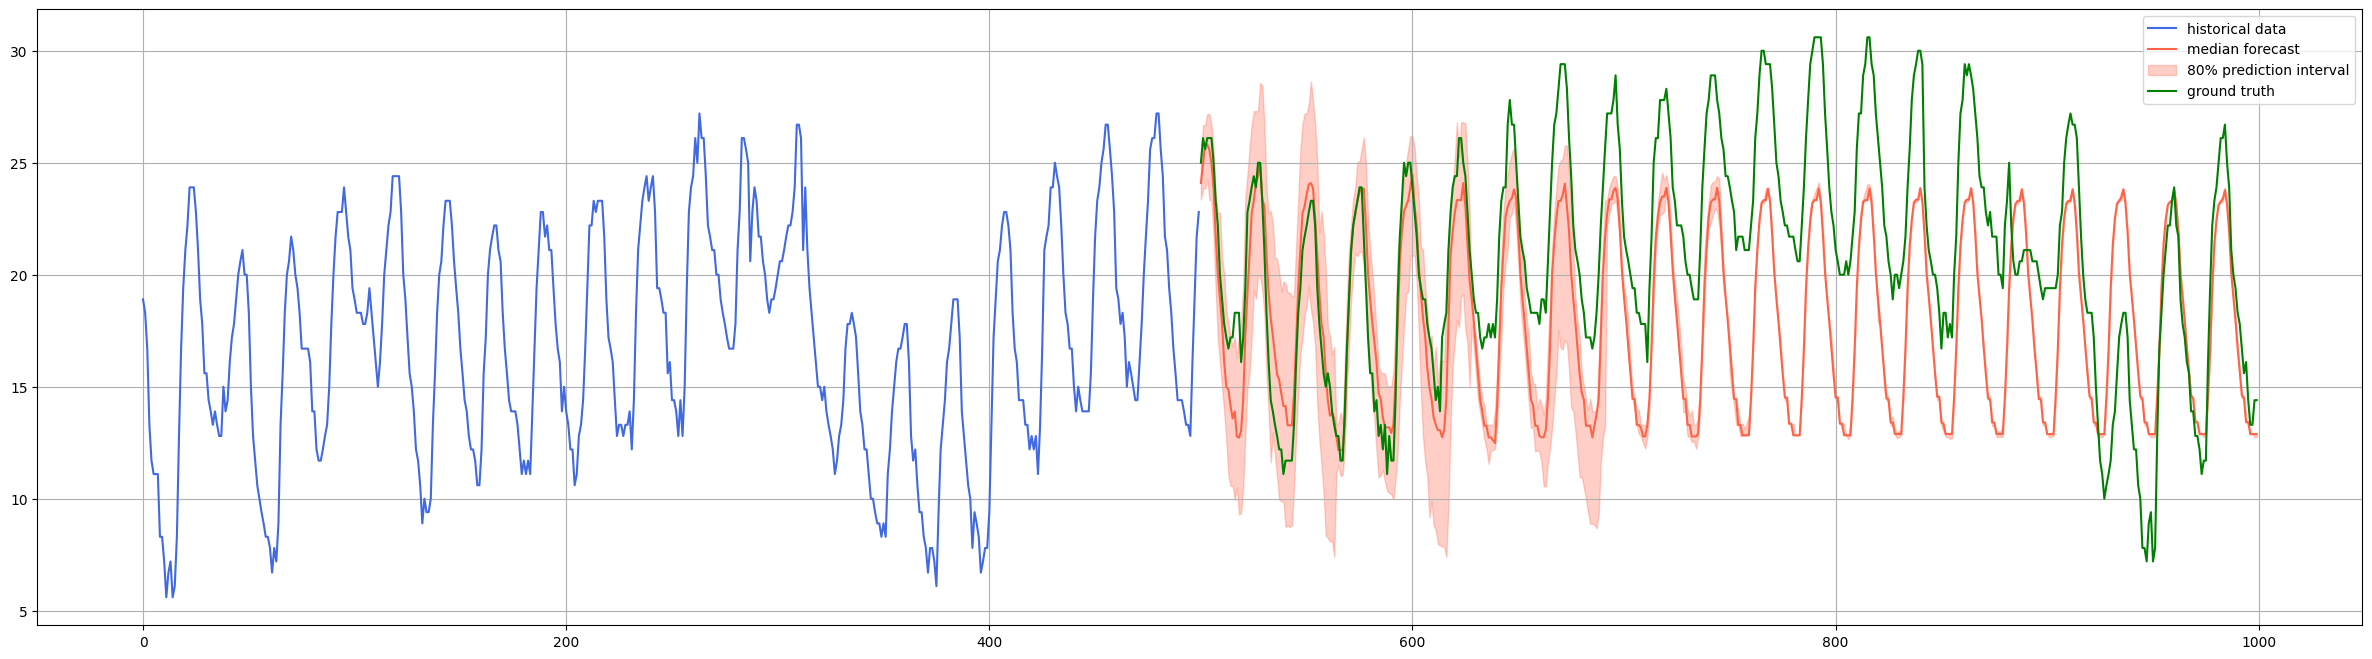

In [52]:
# this code applies choronos pipeline to the data wihtout looking at the future data. 
# This is just to show how chronos will gradually deviate from the data. In this project 
# I only predict one point at a tiem and use the ground truth for next step rather than 
# doing it autoregressively for the entire forecast window

quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(data[100:1500]),
    prediction_length=500,
    quantile_levels=[0.1, 0.5, 0.9],
)

forecast_index = range(len(data[1000:1500]), len(data[1000:1500]) + 500)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(30, 8))
plt.plot(data[1000:1500], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.plot(range(500, 500+500), data[1500:1500+500], color="green", label="ground truth")
plt.legend()
plt.grid()
plt.show()

# adding anomolies

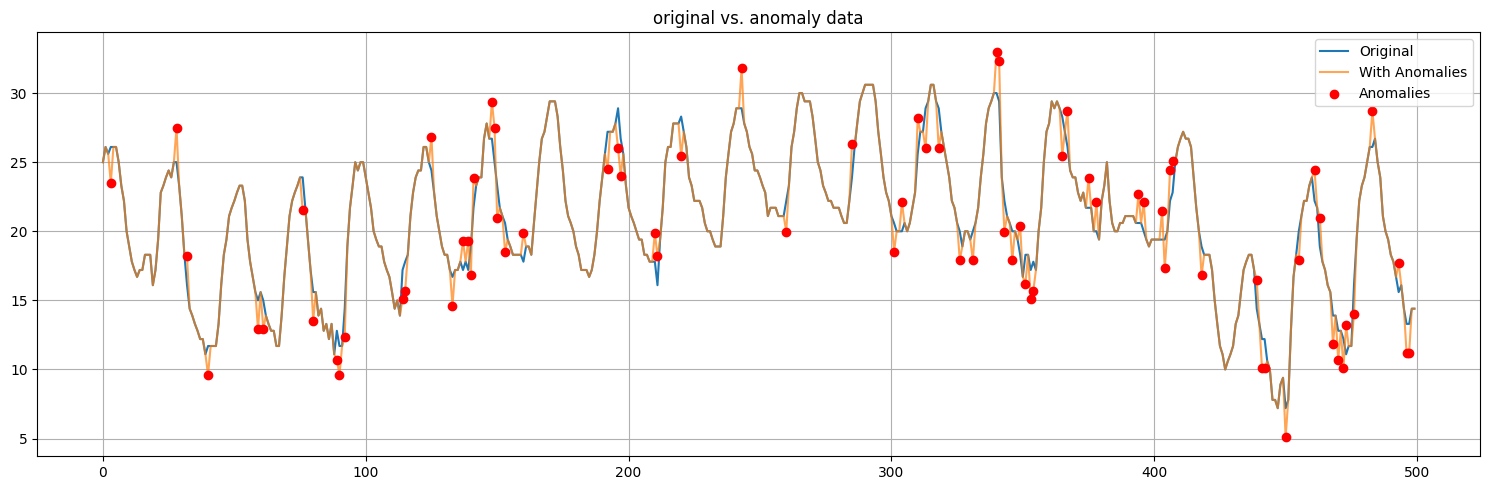

In [53]:
# here we add anomolies to a part of the data. 
# All models are benchmarked by their peroformance in detecting these anomolies for this portion of the data

def add_anomalies(data, target_col="Consumption", anomaly_col="m_bool", 
                                 anomaly_frac=0.15, min_dev_ratio=0.1):

    if isinstance(data, (np.ndarray, list)):
        data = pd.DataFrame({target_col: data})
    else:
        data = data.copy()

    n = len(data)
    n_anomalies = int(anomaly_frac * n)
    indices = np.random.choice(data.index, size=n_anomalies, replace=False)

    avg_load = data[target_col].mean()
    min_deviation = min_dev_ratio * avg_load


    data[f"m_{target_col}"] = data[target_col]
    data[anomaly_col] = False


    for idx in indices:
        original = data.at[idx, target_col]
        deviation = max(0.1 * original, min_deviation)

        if np.random.rand() < 0.5:
            new_val = original - deviation
        else:
            new_val = original + deviation
        data.at[idx, f"m_{target_col}"] = new_val
        data.at[idx, anomaly_col] = True

    return data

data_with_anomalies = add_anomalies(data[1500:2000], target_col="Consumption", anomaly_col="m_bool",
                                 anomaly_frac=0.15, min_dev_ratio=0.1)


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(data_with_anomalies["Consumption"], label="Original")
plt.plot(data_with_anomalies["m_Consumption"], label="With Anomalies", alpha=0.7)
plt.scatter(
    data_with_anomalies.index[data_with_anomalies["m_bool"]],
    data_with_anomalies.loc[data_with_anomalies["m_bool"], "m_Consumption"],
    color="red", label="Anomalies", zorder=5
)
plt.legend()
plt.title("original vs. anomaly data")
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
# input_data = data_with_anomalies["m_Consumption"].values

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def chronos_stepwise_forecast(input_data, pipeline,
                                          context_window=500,
                                          forecast_window=500,
                                          quantile_levels=[0.1, 0.5, 0.9]):
    
    
    low_preds, med_preds, high_preds = [], [], []

    context = list(input_data[0:context_window])

    for t in range(context_window, forecast_window+context_window):
        context_tensor = torch.tensor(context, dtype=torch.float32)

        quantiles, mean = pipeline.predict_quantiles(
            context=context_tensor,
            prediction_length=1,
            quantile_levels=quantile_levels
        )

        low_preds.append(quantiles[0, 0, 0])
        med_preds.append(quantiles[0, 0, 1])
        high_preds.append(quantiles[0, 0, 2])

        context.append(input_data[t])
        context.pop(0)

    return low_preds, med_preds, high_preds



In [56]:
# concatenate the data with anomalies and the original data. This is used to give to Chronos for prediction. 
# We have a window of 500 and we predict one point at a time for 500 points.

anomaly_data = data_with_anomalies["m_Consumption"].values 
all = np.concatenate((data[1000:1500], anomaly_data))
print(all.shape)

# now apply the funciton above to the all data and plot the results
low_preds, med_preds, high_preds = chronos_stepwise_forecast(all, pipeline)

(1000,)


Number of anomalies detected (true positives): 56
Total anomalies in data: 75
Percentage of anomalies detected: 74.67%

Number of false positives: 90
Total non-anomaly points: 425
False positive rate: 21.18%

Confusion Matrix:
True Positives (TP): 56
False Positives (FP): 90
False Negatives (FN): 19
True Negatives (TN): 335

Precision: 0.3836
Recall:    0.7467
F1 Score:  0.5068


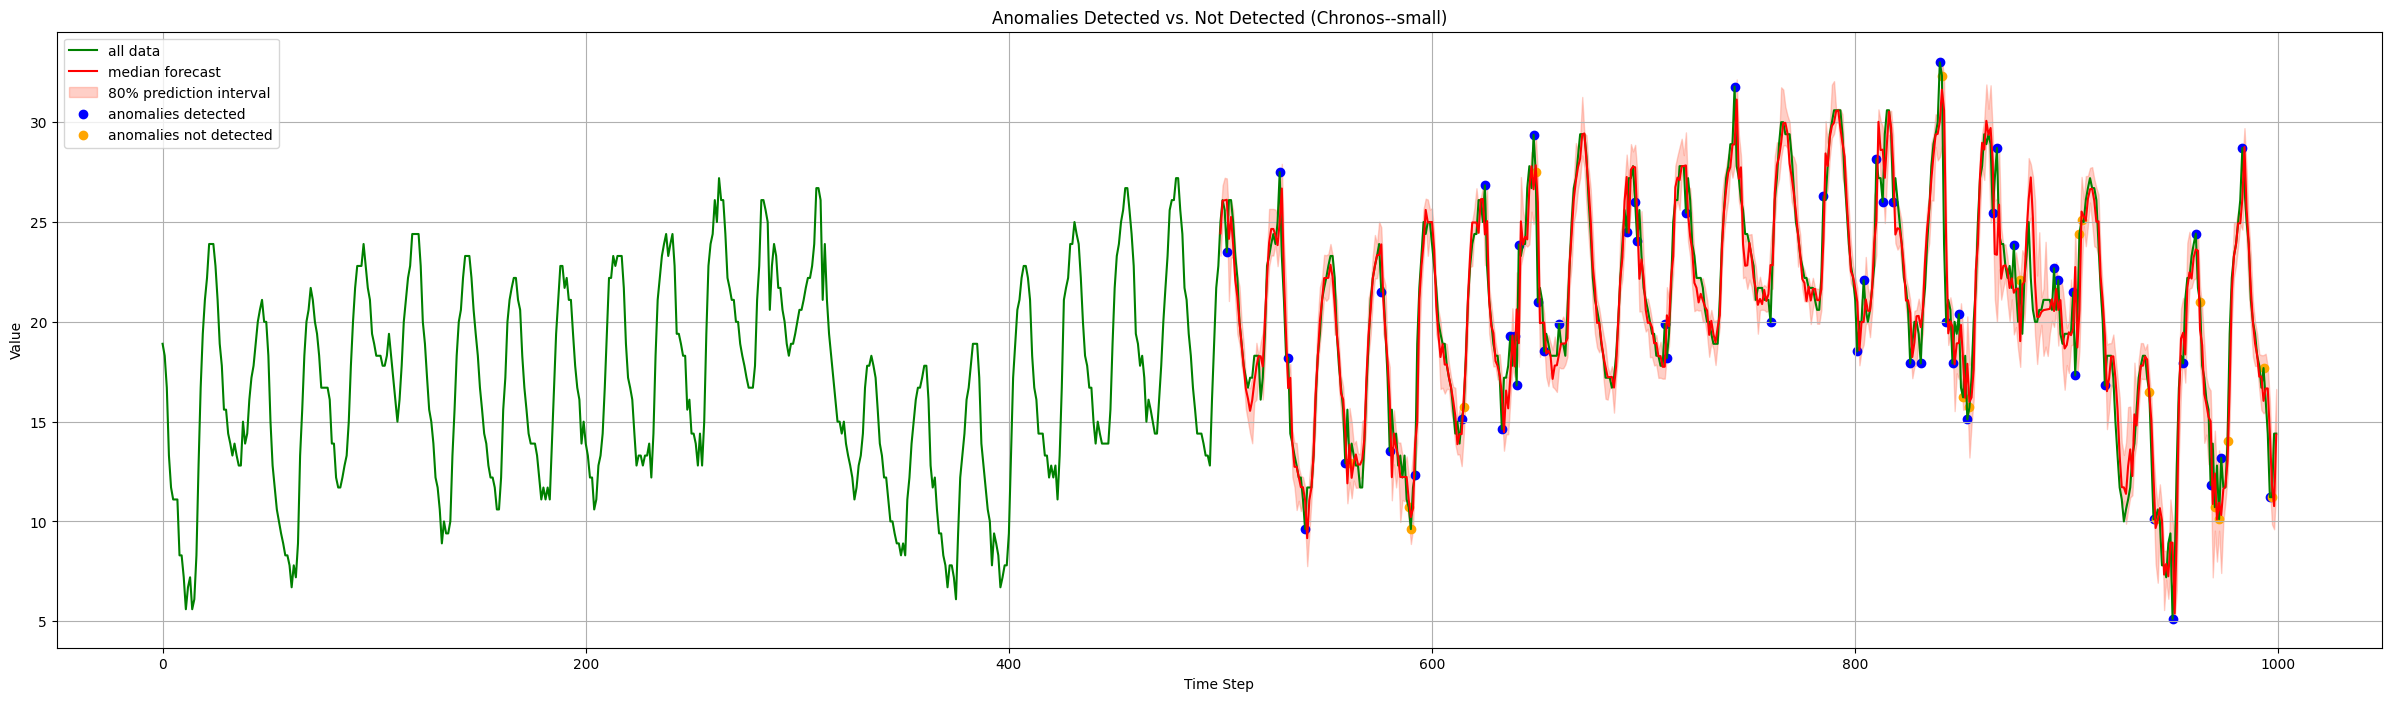

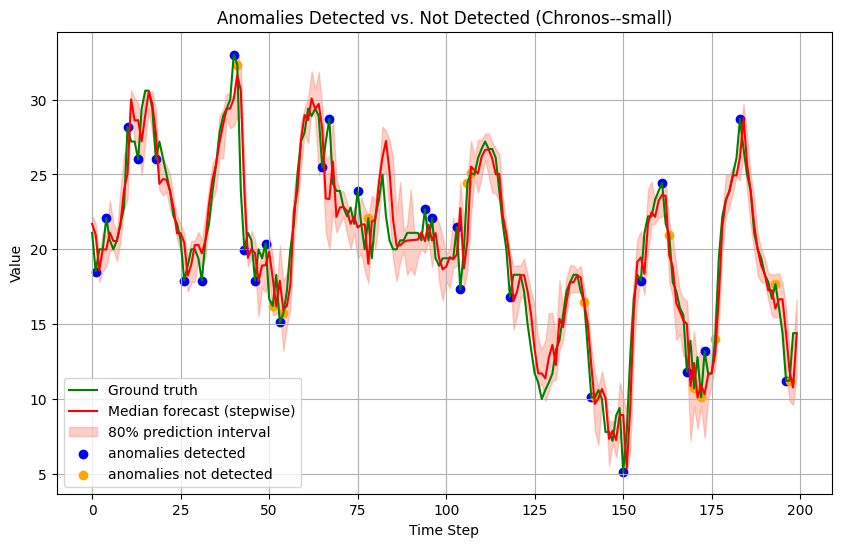

In [58]:
anomaly_data = data_with_anomalies["m_Consumption"].values
anomaly_labels = data_with_anomalies["m_bool"].values


low_preds_p = np.array(low_preds)
high_preds_p = np.array(high_preds)

#  true positives (anomalies detected)
anomaly_indices = np.where(anomaly_labels == True)[0]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]
anomaly_data_subset = anomaly_data[anomaly_indices]

# detected anomalies
anomaly_outside_preds = np.logical_or(
    anomaly_data_subset < anomaly_low_preds,
    anomaly_data_subset > anomaly_high_preds
)

# count anomalies detected
num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)

# false positives (non-anomalies detected as anomalies)
non_anomaly_indices = np.where(anomaly_labels == False)[0]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]
non_anomaly_data_subset = anomaly_data[non_anomaly_indices]

non_anomaly_outside_preds = np.logical_or(
    non_anomaly_data_subset < non_anomaly_low_preds,
    non_anomaly_data_subset > non_anomaly_high_preds
)

# ccount false positives
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")

print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]

detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

plt.figure(figsize=(30, 8))
plt.plot(all, color="green", label="all data")
plt.plot(range(500, 1000), med_preds, color="red", label="median forecast")
plt.fill_between(range(500, 1000), low_preds, high_preds, color="tomato", alpha=0.3, label="80% prediction interval")
plt.scatter(detected_indices + 500, detected_values, color="blue", label="anomalies detected")
plt.scatter(missed_indices + 500, missed_values, color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected (Chronos--small)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all[800:], color="green", label="Ground truth")
plt.plot(range(0,200) ,med_preds[300:], color="red", label="Median forecast (stepwise)")
plt.fill_between(range(0,200), low_preds[300:], high_preds[300:], color="tomato", alpha=0.3, label="80% prediction interval")
# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected (Chronos--small)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()



In [59]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",  
    torch_dtype=torch.bfloat16,
)

(1000,)
Number of anomalies detected (true positives): 56
Total anomalies in data: 75
Percentage of anomalies detected: 74.67%

Number of false positives: 84
Total non-anomaly points: 425
False positive rate: 19.76%

Confusion Matrix:
True Positives (TP): 56
False Positives (FP): 84
False Negatives (FN): 19
True Negatives (TN): 341

Precision: 0.4000
Recall:    0.7467
F1 Score:  0.5209


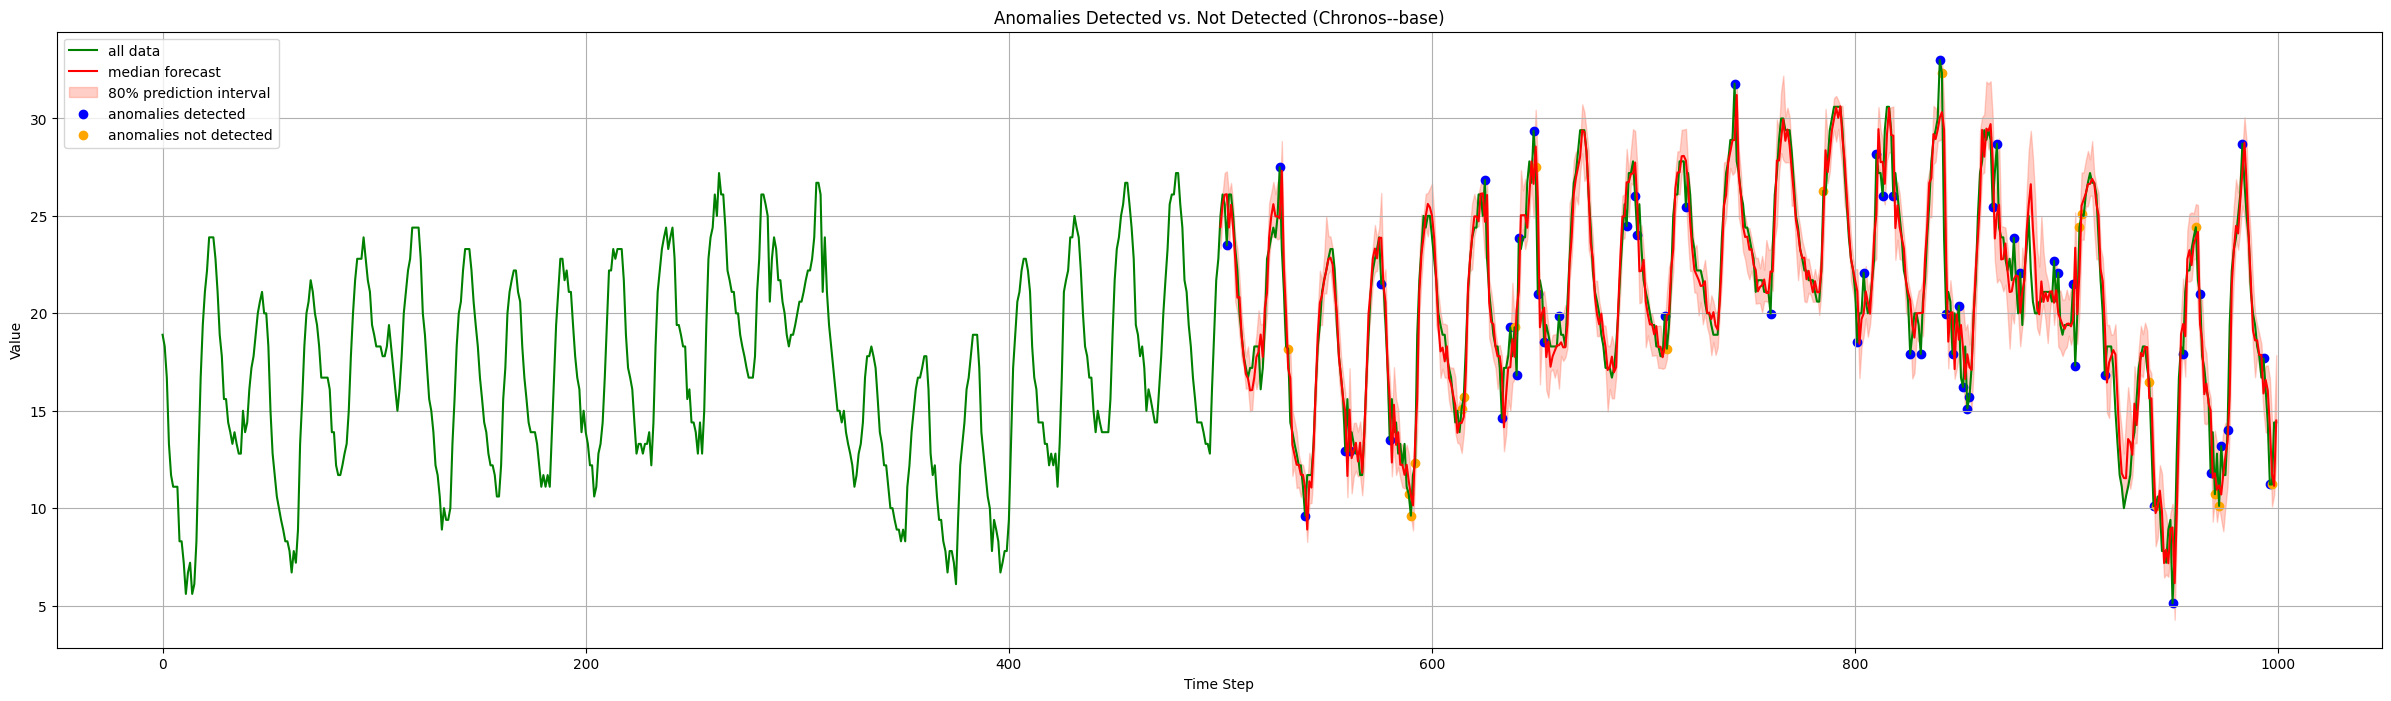

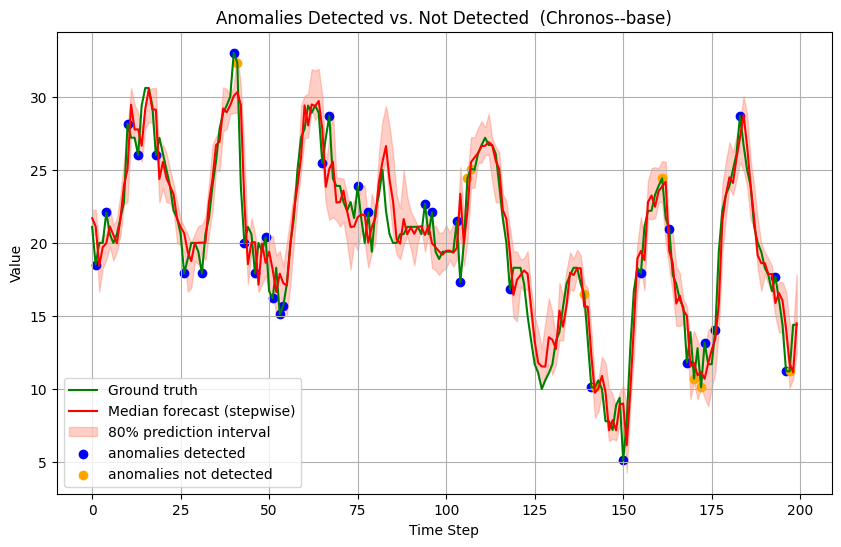

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def chronos_stepwise_forecast(input_data, pipeline,
                                          context_window=500,
                                          forecast_window=500,
                                          quantile_levels=[0.1, 0.5, 0.9]):
    
    
    low_preds, med_preds, high_preds = [], [], []

    context = list(input_data[0:context_window])

    for t in range(context_window, forecast_window+context_window):
        context_tensor = torch.tensor(context, dtype=torch.float32)

        quantiles, mean = pipeline.predict_quantiles(
            context=context_tensor,
            prediction_length=1,
            quantile_levels=quantile_levels
        )

        low_preds.append(quantiles[0, 0, 0])
        med_preds.append(quantiles[0, 0, 1])
        high_preds.append(quantiles[0, 0, 2])

        context.append(input_data[t])
        context.pop(0)

    return low_preds, med_preds, high_preds

# concatenate the data with anomalies and the original data. This is used to give to Chronos for prediction. 
# We have a window of 500 and we predict one point at a time for 500 points.

anomaly_data = data_with_anomalies["m_Consumption"].values 
all = np.concatenate((data[1000:1500], anomaly_data))
print(all.shape)

# now apply the funciton above to the all data and plot the results
low_preds, med_preds, high_preds = chronos_stepwise_forecast(all, pipeline)


anomaly_data = data_with_anomalies["m_Consumption"].values
anomaly_labels = data_with_anomalies["m_bool"].values


low_preds_p = np.array(low_preds)
high_preds_p = np.array(high_preds)

#  true positives (anomalies detected)
anomaly_indices = np.where(anomaly_labels == True)[0]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]
anomaly_data_subset = anomaly_data[anomaly_indices]

# detected anomalies
anomaly_outside_preds = np.logical_or(
    anomaly_data_subset < anomaly_low_preds,
    anomaly_data_subset > anomaly_high_preds
)

# count anomalies detected
num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)

# false positives (non-anomalies detected as anomalies)
non_anomaly_indices = np.where(anomaly_labels == False)[0]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]
non_anomaly_data_subset = anomaly_data[non_anomaly_indices]

non_anomaly_outside_preds = np.logical_or(
    non_anomaly_data_subset < non_anomaly_low_preds,
    non_anomaly_data_subset > non_anomaly_high_preds
)

# ccount false positives
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")

print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]

detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

plt.figure(figsize=(30, 8))
plt.plot(all, color="green", label="all data")
plt.plot(range(500, 1000), med_preds, color="red", label="median forecast")
plt.fill_between(range(500, 1000), low_preds, high_preds, color="tomato", alpha=0.3, label="80% prediction interval")
plt.scatter(detected_indices + 500, detected_values, color="blue", label="anomalies detected")
plt.scatter(missed_indices + 500, missed_values, color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected (Chronos--base)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all[800:], color="green", label="Ground truth")
plt.plot(range(0,200) ,med_preds[300:], color="red", label="Median forecast (stepwise)")
plt.fill_between(range(0,200), low_preds[300:], high_preds[300:], color="tomato", alpha=0.3, label="80% prediction interval")
# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (Chronos--base)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()



# chronos tiny

In [61]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  
    torch_dtype=torch.bfloat16,
)

(1000,)
Number of anomalies detected (true positives): 51
Total anomalies in data: 75
Percentage of anomalies detected: 68.00%

Number of false positives: 77
Total non-anomaly points: 425
False positive rate: 18.12%

Confusion Matrix:
True Positives (TP): 51
False Positives (FP): 77
False Negatives (FN): 24
True Negatives (TN): 348

Precision: 0.3984
Recall:    0.6800
F1 Score:  0.5025


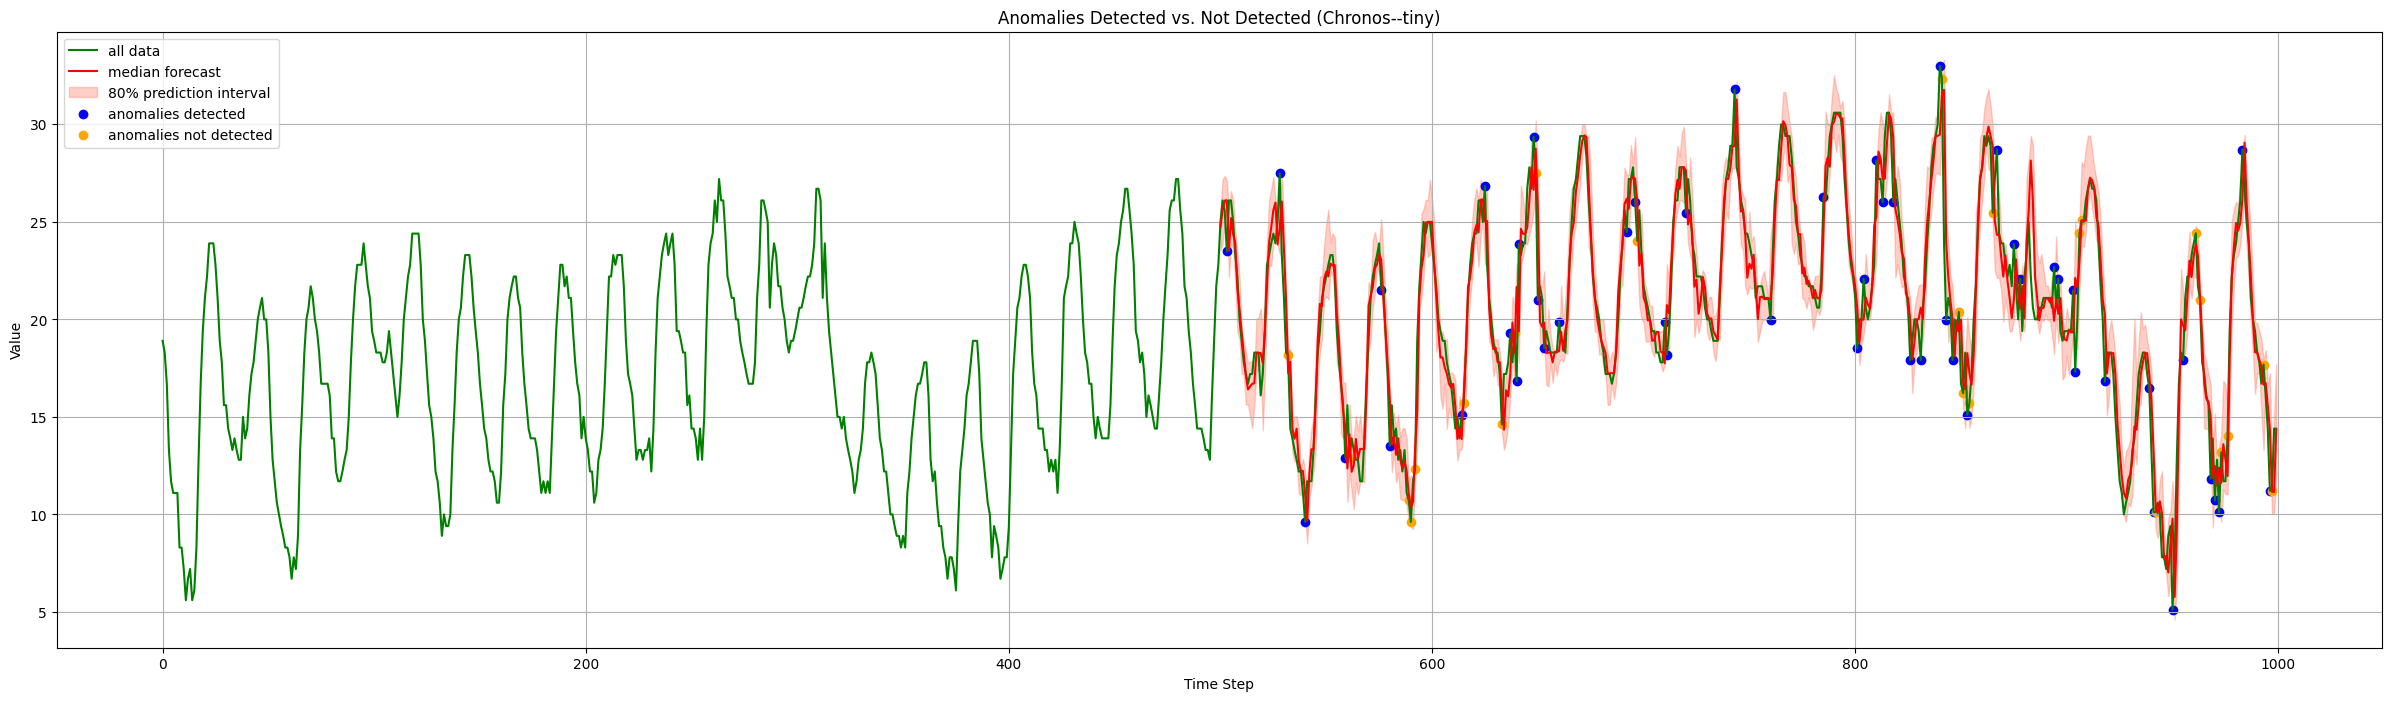

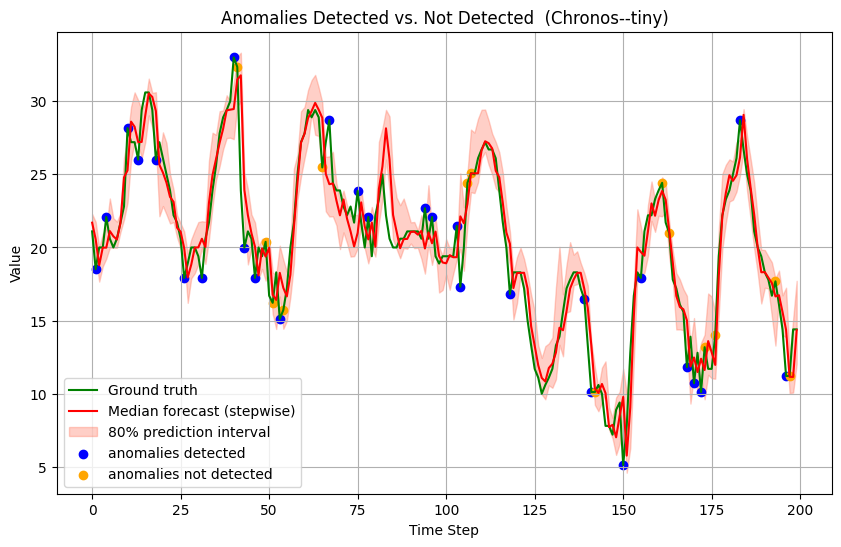

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def chronos_stepwise_forecast(input_data, pipeline,
                                          context_window=500,
                                          forecast_window=500,
                                          quantile_levels=[0.1, 0.5, 0.9]):
    
    
    low_preds, med_preds, high_preds = [], [], []

    context = list(input_data[0:context_window])

    for t in range(context_window, forecast_window+context_window):
        context_tensor = torch.tensor(context, dtype=torch.float32)

        quantiles, mean = pipeline.predict_quantiles(
            context=context_tensor,
            prediction_length=1,
            quantile_levels=quantile_levels
        )

        low_preds.append(quantiles[0, 0, 0])
        med_preds.append(quantiles[0, 0, 1])
        high_preds.append(quantiles[0, 0, 2])

        context.append(input_data[t])
        context.pop(0)

    return low_preds, med_preds, high_preds

# concatenate the data with anomalies and the original data. This is used to give to Chronos for prediction. 
# We have a window of 500 and we predict one point at a time for 500 points.

anomaly_data = data_with_anomalies["m_Consumption"].values 
all = np.concatenate((data[1000:1500], anomaly_data))
print(all.shape)

# now apply the funciton above to the all data and plot the results
low_preds, med_preds, high_preds = chronos_stepwise_forecast(all, pipeline)


anomaly_data = data_with_anomalies["m_Consumption"].values
anomaly_labels = data_with_anomalies["m_bool"].values


low_preds_p = np.array(low_preds)
high_preds_p = np.array(high_preds)

#  true positives (anomalies detected)
anomaly_indices = np.where(anomaly_labels == True)[0]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]
anomaly_data_subset = anomaly_data[anomaly_indices]

# detected anomalies
anomaly_outside_preds = np.logical_or(
    anomaly_data_subset < anomaly_low_preds,
    anomaly_data_subset > anomaly_high_preds
)

# count anomalies detected
num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)

# false positives (non-anomalies detected as anomalies)
non_anomaly_indices = np.where(anomaly_labels == False)[0]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]
non_anomaly_data_subset = anomaly_data[non_anomaly_indices]

non_anomaly_outside_preds = np.logical_or(
    non_anomaly_data_subset < non_anomaly_low_preds,
    non_anomaly_data_subset > non_anomaly_high_preds
)

# ccount false positives
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")

print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]

detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

plt.figure(figsize=(30, 8))
plt.plot(all, color="green", label="all data")
plt.plot(range(500, 1000), med_preds, color="red", label="median forecast")
plt.fill_between(range(500, 1000), low_preds, high_preds, color="tomato", alpha=0.3, label="80% prediction interval")
plt.scatter(detected_indices + 500, detected_values, color="blue", label="anomalies detected")
plt.scatter(missed_indices + 500, missed_values, color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected (Chronos--tiny)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all[800:], color="green", label="Ground truth")
plt.plot(range(0,200) ,med_preds[300:], color="red", label="Median forecast (stepwise)")
plt.fill_between(range(0,200), low_preds[300:], high_preds[300:], color="tomato", alpha=0.3, label="80% prediction interval")
# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (Chronos--tiny)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()



# chronos large

In [48]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  
    torch_dtype=torch.bfloat16,
)

c:\Users\navid-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\navid-pc\.cache\huggingface\hub\models--amazon--chronos-t5-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(1000,)
Number of anomalies detected (true positives): 55
Total anomalies in data: 75
Percentage of anomalies detected: 73.33%

Number of false positives: 72
Total non-anomaly points: 425
False positive rate: 16.94%

Confusion Matrix:
True Positives (TP): 55
False Positives (FP): 72
False Negatives (FN): 20
True Negatives (TN): 353

Precision: 0.4331
Recall:    0.7333
F1 Score:  0.5446


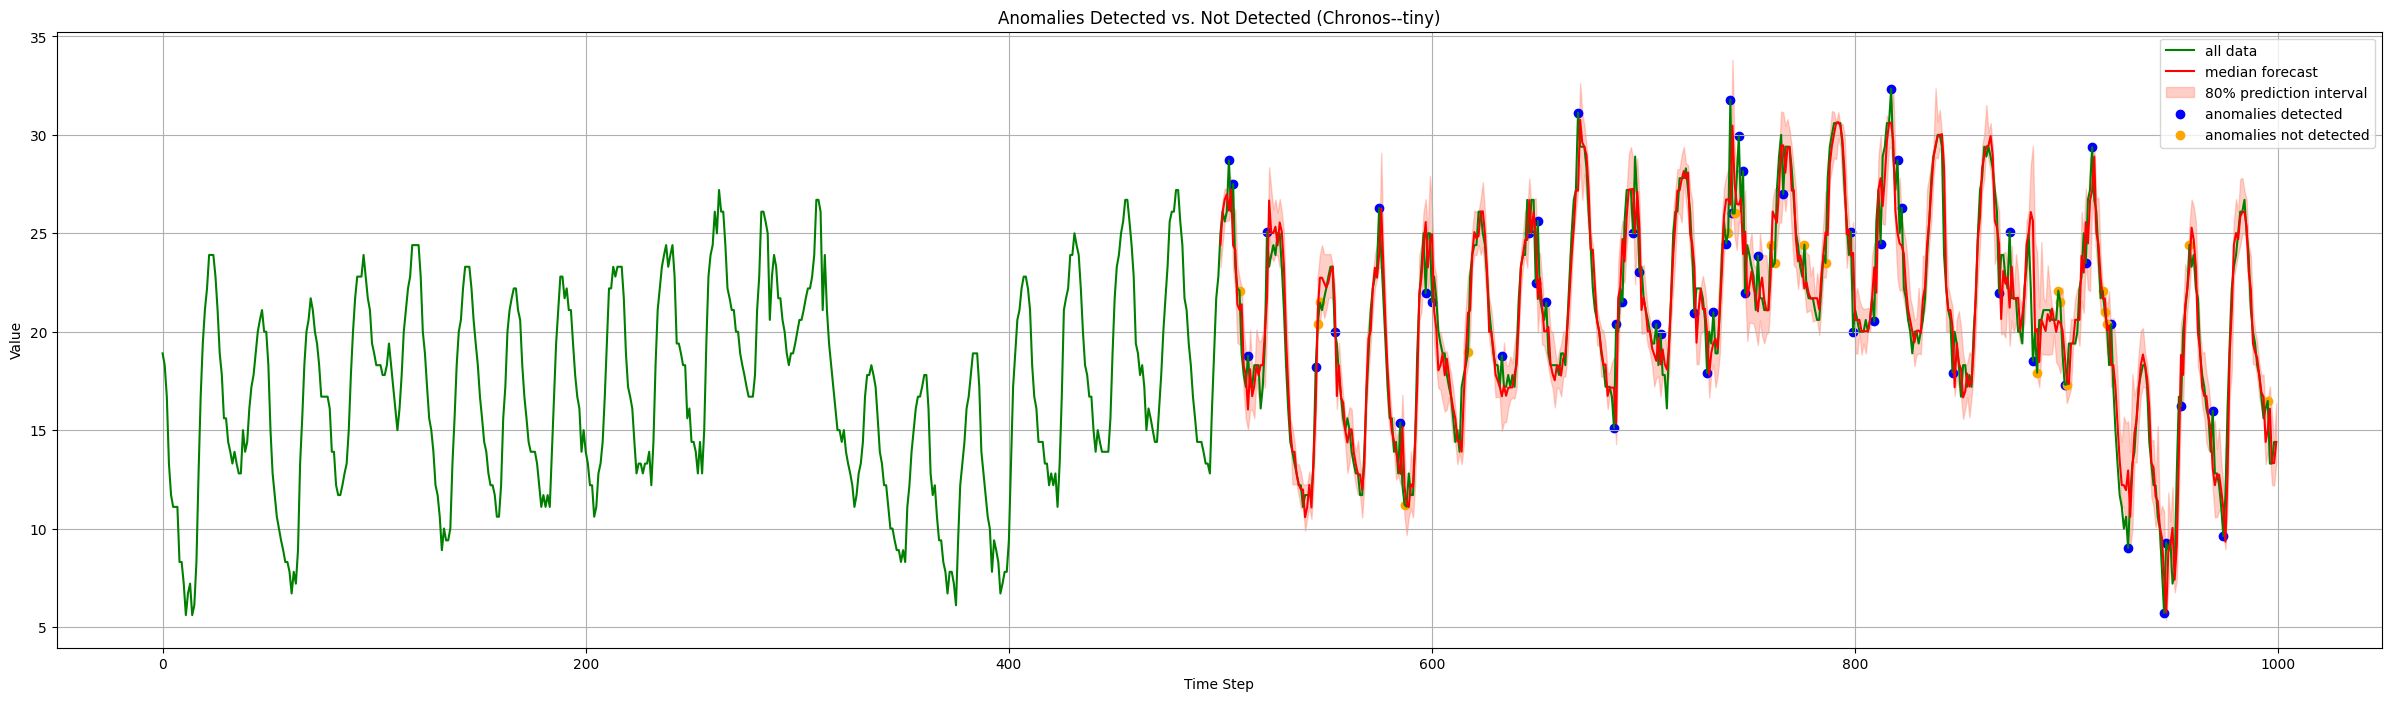

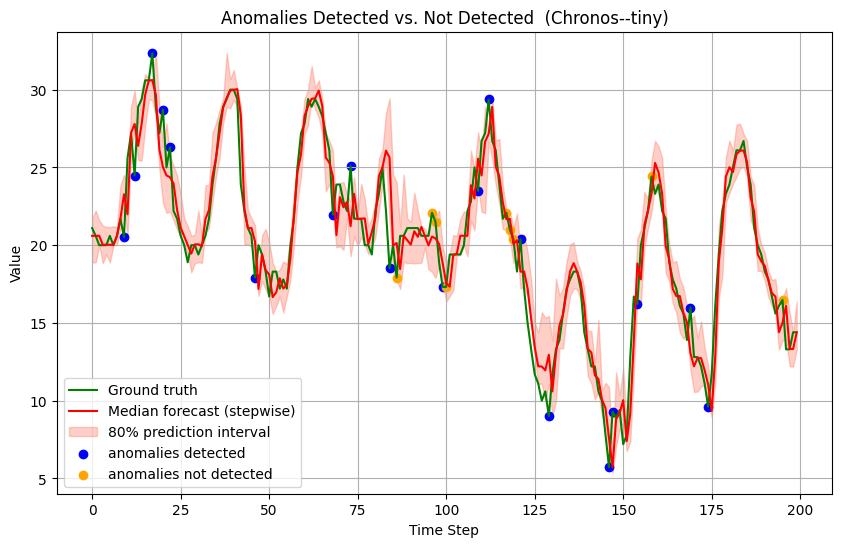

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def chronos_stepwise_forecast(input_data, pipeline,
                                          context_window=500,
                                          forecast_window=500,
                                          quantile_levels=[0.1, 0.5, 0.9]):
    
    
    low_preds, med_preds, high_preds = [], [], []

    context = list(input_data[0:context_window])

    for t in range(context_window, forecast_window+context_window):
        context_tensor = torch.tensor(context, dtype=torch.float32)

        quantiles, mean = pipeline.predict_quantiles(
            context=context_tensor,
            prediction_length=1,
            quantile_levels=quantile_levels
        )

        low_preds.append(quantiles[0, 0, 0])
        med_preds.append(quantiles[0, 0, 1])
        high_preds.append(quantiles[0, 0, 2])

        context.append(input_data[t])
        context.pop(0)

    return low_preds, med_preds, high_preds

# concatenate the data with anomalies and the original data. This is used to give to Chronos for prediction. 
# We have a window of 500 and we predict one point at a time for 500 points.

anomaly_data = data_with_anomalies["m_Consumption"].values 
all = np.concatenate((data[1000:1500], anomaly_data))
print(all.shape)

# now apply the funciton above to the all data and plot the results
low_preds, med_preds, high_preds = chronos_stepwise_forecast(all, pipeline)


anomaly_data = data_with_anomalies["m_Consumption"].values
anomaly_labels = data_with_anomalies["m_bool"].values


low_preds_p = np.array(low_preds)
high_preds_p = np.array(high_preds)

#  true positives (anomalies detected)
anomaly_indices = np.where(anomaly_labels == True)[0]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]
anomaly_data_subset = anomaly_data[anomaly_indices]

# detected anomalies
anomaly_outside_preds = np.logical_or(
    anomaly_data_subset < anomaly_low_preds,
    anomaly_data_subset > anomaly_high_preds
)

# count anomalies detected
num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)

# false positives (non-anomalies detected as anomalies)
non_anomaly_indices = np.where(anomaly_labels == False)[0]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]
non_anomaly_data_subset = anomaly_data[non_anomaly_indices]

non_anomaly_outside_preds = np.logical_or(
    non_anomaly_data_subset < non_anomaly_low_preds,
    non_anomaly_data_subset > non_anomaly_high_preds
)

# ccount false positives
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")

print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]

detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

plt.figure(figsize=(30, 8))
plt.plot(all, color="green", label="all data")
plt.plot(range(500, 1000), med_preds, color="red", label="median forecast")
plt.fill_between(range(500, 1000), low_preds, high_preds, color="tomato", alpha=0.3, label="80% prediction interval")
plt.scatter(detected_indices + 500, detected_values, color="blue", label="anomalies detected")
plt.scatter(missed_indices + 500, missed_values, color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected (Chronos--tiny)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all[800:], color="green", label="Ground truth")
plt.plot(range(0,200) ,med_preds[300:], color="red", label="Median forecast (stepwise)")
plt.fill_between(range(0,200), low_preds[300:], high_preds[300:], color="tomato", alpha=0.3, label="80% prediction interval")
# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (Chronos--tiny)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()



# TimeGPT-1 

In [31]:
import pandas as pd
from nixtla import NixtlaClient

In [32]:
nixtla_client = NixtlaClient(api_key = 'nixak-TXKqEATPrKMuC0Si7Hk8uZXy5RL0gTQ628SvRKs3mwAiSVWw6zKtNASRGOqqv5nAKQ4yU29SwtcOybkW')

In [33]:
ds = pd.date_range(start='2023-01-01', periods=len(data[1000:1500]), freq='1H')

df = pd.DataFrame({
    'unique_id': 'signal_1',
    'ds': ds,
    'y': data[1000:1500]
})

fcst_df = nixtla_client.forecast(df, h=100, level=[80])
fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


unique_id                  ds    TimeGPT  TimeGPT-hi-80  TimeGPT-lo-80
0  signal_1 2023-01-21 20:00:00  23.954979      24.903477      23.006481
1  signal_1 2023-01-21 21:00:00  24.870174      26.026203      23.714146
2  signal_1 2023-01-21 22:00:00  25.285984      26.986185      23.585783
3  signal_1 2023-01-21 23:00:00  25.725502      27.885979      23.565025
4  signal_1 2023-01-22 00:00:00  25.474003      27.472020      23.475986

In [34]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def timegpt_stepwise_forecast(input_data,
                               nixtla_client,
                               context_window=500,
                               forecast_window=500,
                               level=80,
                               freq="1H"):

    low_preds, med_preds, high_preds = [], [], []

    context = list(input_data[0:context_window])

    for t in tqdm(range(context_window, forecast_window + context_window)):
        ds = pd.date_range(start='2023-01-01', periods=context_window, freq=freq)
        df = pd.DataFrame({
            'unique_id': 'signal_1',
            'ds': ds,
            'y': context
        })

        fcst_df = nixtla_client.forecast(df, h=1, level=[level])

        low = fcst_df[f"TimeGPT-lo-{level}"].values[0]
        mid = fcst_df["TimeGPT"].values[0]
        high =fcst_df[f"TimeGPT-hi-{level}"].values[0]

        low_preds.append(low)
        med_preds.append(mid)
        high_preds.append(high)

        context.append(input_data[t])
        context.pop(0)

    return np.array(low_preds), np.array(med_preds), np.array(high_preds)


In [35]:
low_preds, med_preds, high_preds = timegpt_stepwise_forecast(all, nixtla_client)

  0%|          | 0/500 [00:00<?, ?it/s]INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
  0%|          | 1/500 [00:02<21:10,  2.55s/it]INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
  0%|          | 2/500 [00:03<12:57,  1.56s/it]INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
  1%|          | 3/500 [00:04<09:45,  1.18s/it]INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred 

Number of anomalies detected (true positives): 52
Total anomalies in data: 75
Percentage of anomalies detected: 69.33%

Number of false positives: 100
Total non-anomaly points: 425
False positive rate: 23.53%

Confusion Matrix:
True Positives (TP): 52
False Positives (FP): 100
False Negatives (FN): 23
True Negatives (TN): 325

Precision: 0.3421
Recall:    0.6933
F1 Score:  0.4581


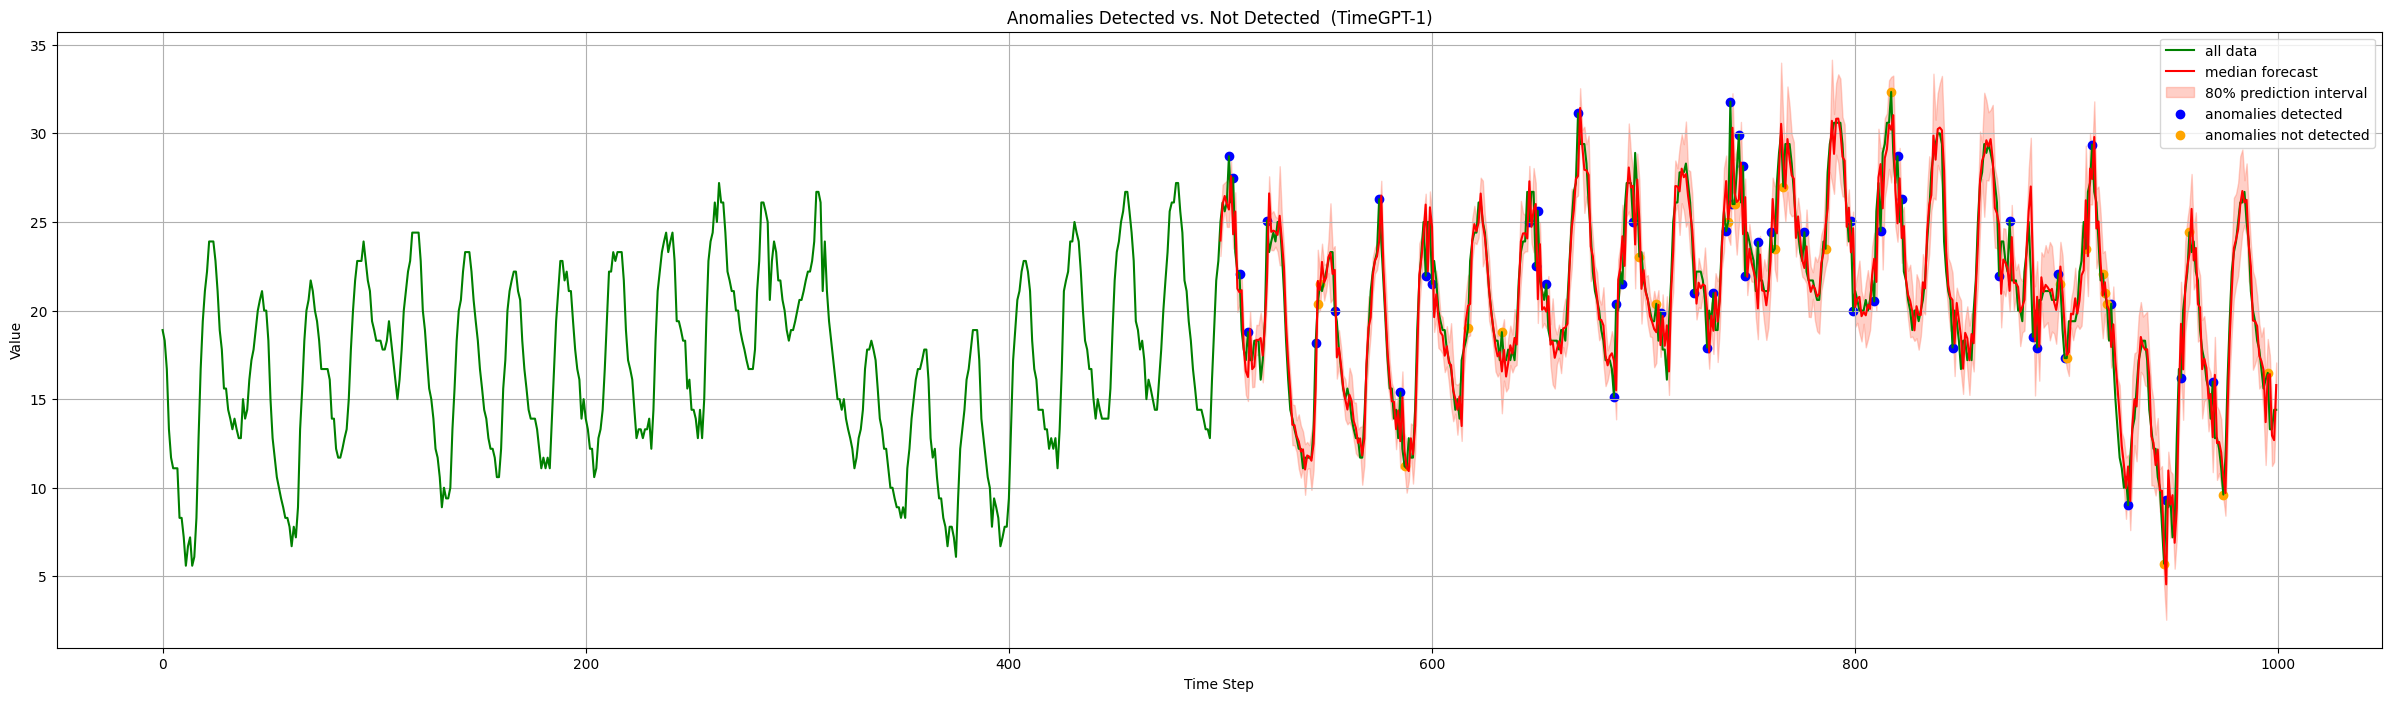

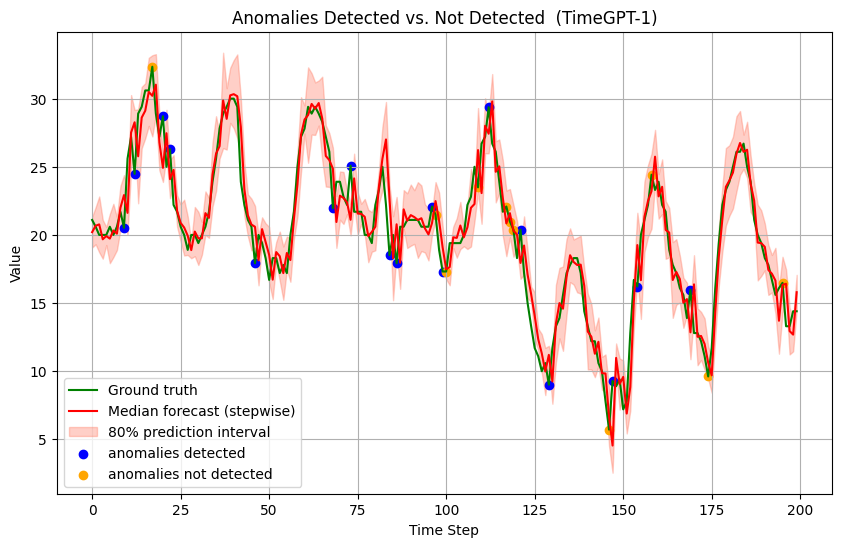

In [37]:
anomaly_data = data_with_anomalies["m_Consumption"].values
anomaly_labels = data_with_anomalies["m_bool"].values

low_preds_p = np.array(low_preds)
high_preds_p = np.array(high_preds)

#  true positives (anomalies detected)
anomaly_indices = np.where(anomaly_labels == True)[0]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]
anomaly_data_subset = anomaly_data[anomaly_indices]

# anomolies
anomaly_outside_preds = np.logical_or(
    anomaly_data_subset < anomaly_low_preds,
    anomaly_data_subset > anomaly_high_preds
)

# Counting them
num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)

# false positives (non-anomalies detected as anomalies)
non_anomaly_indices = np.where(anomaly_labels == False)[0]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]
non_anomaly_data_subset = anomaly_data[non_anomaly_indices]

non_anomaly_outside_preds = np.logical_or(
    non_anomaly_data_subset < non_anomaly_low_preds,
    non_anomaly_data_subset > non_anomaly_high_preds
)

# counting
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")

print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]

detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

plt.figure(figsize=(30, 8))
plt.plot(all, color="green", label="all data")
plt.plot(range(500, 1000), med_preds, color="red", label="median forecast")
plt.fill_between(range(500, 1000), low_preds, high_preds, color="tomato", alpha=0.3, label="80% prediction interval")
plt.scatter(detected_indices + 500, detected_values, color="blue", label="anomalies detected")
plt.scatter(missed_indices + 500, missed_values, color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (TimeGPT-1)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all[800:], color="green", label="Ground truth")
plt.plot(range(0,200) ,med_preds[300:], color="red", label="Median forecast (stepwise)")
plt.fill_between(range(0,200), low_preds[300:], high_preds[300:], color="tomato", alpha=0.3, label="80% prediction interval")
# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (TimeGPT-1)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


# EnbPI

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from mapie.time_series_regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

context_size = 499
train_range = (0, 1500)
test_range = (1500, 2000)
test_context_start = test_range[0] - context_size 

test_with_context = data[test_context_start:test_range[1]]

df_test = pd.DataFrame({
    "ds": pd.date_range("2023-01-01", periods=len(test_with_context), freq="H"),
    "y": test_with_context
})

for lag in range(1, context_size + 1):
    df_test[f"lag_{lag}"] = df_test["y"].shift(lag)
df_test.dropna(inplace=True)

X_test = df_test[[f"lag_{lag}" for lag in range(1, context_size + 1)]]
y_test = df_test["y"]

train_data = data[train_range[0]:train_range[1]]
df_train = pd.DataFrame({
    "ds": pd.date_range("2022-01-01", periods=len(train_data), freq="H"),
    "y": train_data
})

for lag in range(1, context_size + 1):
    df_train[f"lag_{lag}"] = df_train["y"].shift(lag)
df_train.dropna(inplace=True)

X_train = df_train[[f"lag_{lag}" for lag in range(1, context_size + 1)]]
y_train = df_train["y"]

# train EnbPI
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
cv = BlockBootstrap(n_resamplings=10, length=24, random_state=0)
mapie = MapieTimeSeriesRegressor(estimator=model, method="enbpi", cv=cv, agg_function="mean")
mapie.fit(X_train, y_train)

y_pred, y_pis = mapie.predict(X_test, alpha=0.2)

C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\1368472887.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[f"lag_{lag}"] = df_test["y"].shift(lag)
C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\1368472887.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[f"lag_{lag}"] = df_test["y"].shift(lag)
C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\1368472887.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

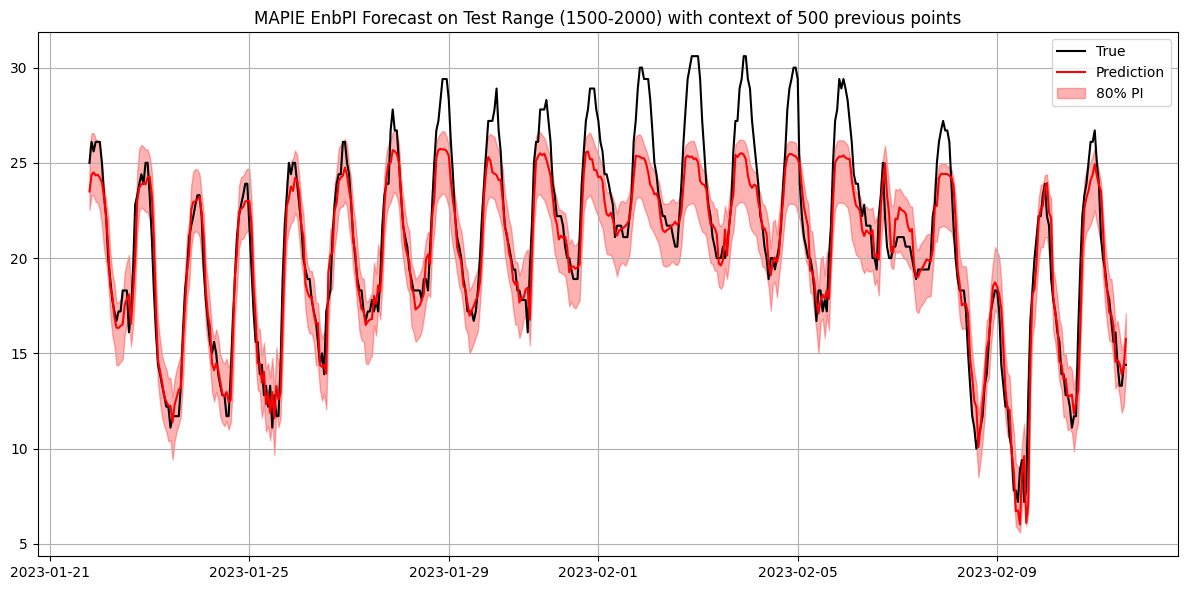

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(df_test["ds"], y_test, label="True", color="black")
plt.plot(df_test["ds"], y_pred, label="Prediction", color="red")
plt.fill_between(df_test["ds"], y_pis[:, 0, 0], y_pis[:, 1, 0],
                 color="red", alpha=0.3, label="80% PI")
plt.title("MAPIE EnbPI Forecast on Test Range (1500-2000) with context of 500 previous points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\2834158788.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[f"lag_{lag}"] = df_test["y"].shift(lag)
C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\2834158788.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[f"lag_{lag}"] = df_test["y"].shift(lag)
C:\Users\navid-pc\AppData\Local\Temp\ipykernel_19608\2834158788.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

Number of anomalies detected (true positives): 46
Total anomalies in data: 75
Percentage of anomalies detected: 61.33%

Number of false positives: 138
Total non-anomaly points: 425
False positive rate: 32.47%

Confusion Matrix:
True Positives (TP): 46
False Positives (FP): 138
False Negatives (FN): 29
True Negatives (TN): 287

Precision: 0.2500
Recall:    0.6133
F1 Score:  0.3552


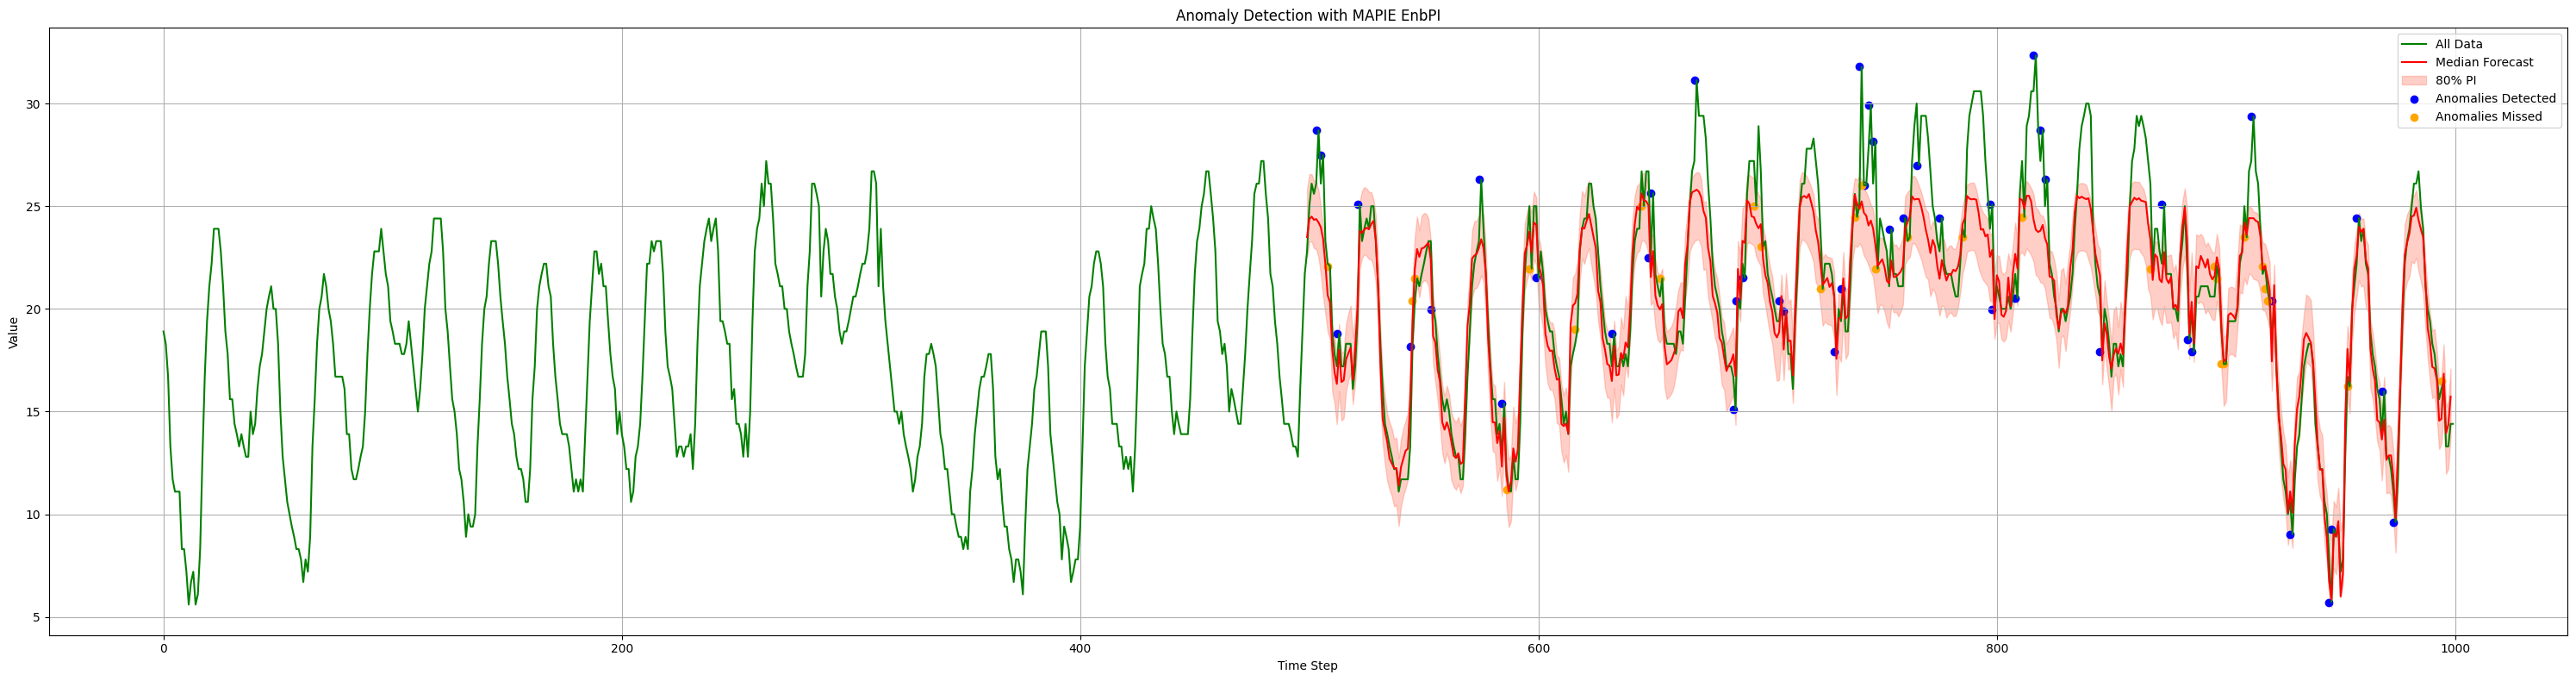

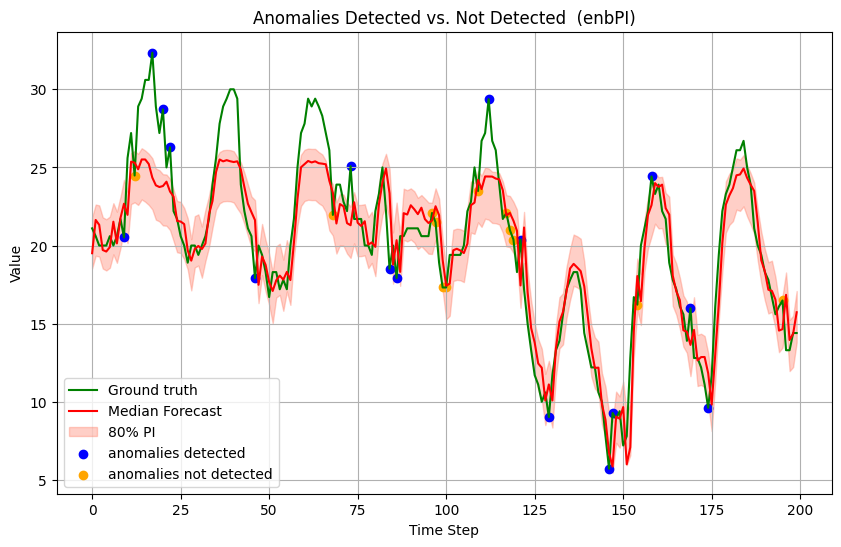

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

anomaly_data = data_with_anomalies["m_Consumption"].values  
anomaly_labels = data_with_anomalies["m_bool"].values       
all_data = np.concatenate([data[1000:1500], anomaly_data])  

df_test = pd.DataFrame({"y": all_data})
for lag in range(1, 500):
    df_test[f"lag_{lag}"] = df_test["y"].shift(lag)

df_test.dropna(inplace=True)

X_all = df_test[[f"lag_{lag}" for lag in range(1, 500)]].values
y_all = df_test["y"].values  

y_pred, y_pis = mapie.predict(X_all, alpha=0.2)
low_preds = y_pis[:, 0, 0]
high_preds = y_pis[:, 1, 0]
med_preds = y_pred

low_preds_p = low_preds[-500:]
high_preds_p = high_preds[-500:]
med_preds_p = med_preds[-500:]

anomaly_indices = np.where(anomaly_labels == True)[0]
non_anomaly_indices = np.where(anomaly_labels == False)[0]

anomaly_data_subset = anomaly_data[anomaly_indices]
anomaly_low_preds = low_preds_p[anomaly_indices]
anomaly_high_preds = high_preds_p[anomaly_indices]

non_anomaly_data_subset = anomaly_data[non_anomaly_indices]
non_anomaly_low_preds = low_preds_p[non_anomaly_indices]
non_anomaly_high_preds = high_preds_p[non_anomaly_indices]

anomaly_outside_preds = (anomaly_data_subset < anomaly_low_preds) | (anomaly_data_subset > anomaly_high_preds)
non_anomaly_outside_preds = (non_anomaly_data_subset < non_anomaly_low_preds) | (non_anomaly_data_subset > non_anomaly_high_preds)

num_anomalies_detected = np.sum(anomaly_outside_preds)
num_anomalies = len(anomaly_indices)
num_false_positives = np.sum(non_anomaly_outside_preds)
num_non_anomalies = len(non_anomaly_indices)

print(f"Number of anomalies detected (true positives): {num_anomalies_detected}")
print(f"Total anomalies in data: {num_anomalies}")
print(f"Percentage of anomalies detected: {num_anomalies_detected / num_anomalies * 100:.2f}%\n")
print(f"Number of false positives: {num_false_positives}")
print(f"Total non-anomaly points: {num_non_anomalies}")
print(f"False positive rate: {num_false_positives / num_non_anomalies * 100:.2f}%")

detected_indices = anomaly_indices[anomaly_outside_preds]
missed_indices = anomaly_indices[~anomaly_outside_preds]
detected_values = anomaly_data_subset[anomaly_outside_preds]
missed_values = anomaly_data_subset[~anomaly_outside_preds]

from sklearn.metrics import precision_score, recall_score, f1_score

TP = num_anomalies_detected  # True Positives: anomalies correctly detected
FP = num_false_positives     # False Positives: normal points incorrectly flagged
FN = num_anomalies - TP      # False Negatives: anomalies missed
TN = num_non_anomalies - FP  # True Negatives: normal points correctly not flagged

print("\nConfusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



plt.figure(figsize=(30, 8))
plt.plot(all_data, color="green", label="All Data")
plt.plot(range(499, 999), med_preds_p, color="red", label="Median Forecast")
plt.fill_between(range(499, 999), low_preds_p, high_preds_p, color="tomato", alpha=0.3, label="80% PI")
plt.scatter(detected_indices + 499, detected_values, color="blue", label="Anomalies Detected")
plt.scatter(missed_indices + 499, missed_values, color="orange", label="Anomalies Missed")
plt.title("Anomalies Detected vs. Not Detected (enbPI)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.title("Anomaly Detection with MAPIE EnbPI")
plt.tight_layout()
plt.show()

# plotting another graph of only the second half of the data (anomalous part)


plt.figure(figsize=(10, 6))
plt.plot(all_data[-200:], color="green", label="Ground truth")
plt.plot(range(0, 200), med_preds_p[-200:], color="red", label="Median Forecast")
plt.fill_between(range(0, 200), low_preds_p[-200:], high_preds_p[-200:], color="tomato", alpha=0.3, label="80% PI")

# plt.scatter(detected_indices, detected_values, color="blue", label="anomalies detected")
# plt.scatter(missed_indices, missed_values, color="orange", label="anomalies not detected")
#only plot scatter points that are more than 300. I removed the first 300. so shift the indices by 300
plt.scatter(detected_indices[detected_indices > 300] - 300, detected_values[detected_indices > 300], color="blue", label="anomalies detected")
plt.scatter(missed_indices[missed_indices > 300] - 300, missed_values[missed_indices > 300], color="orange", label="anomalies not detected")
plt.title("Anomalies Detected vs. Not Detected  (enbPI)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


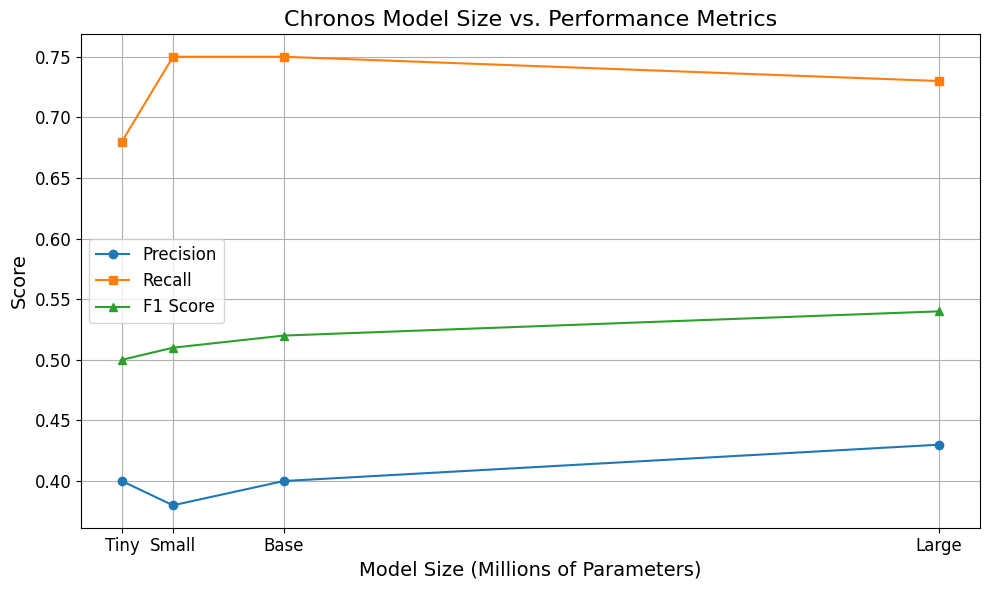

In [64]:
import matplotlib.pyplot as plt

# Model names in increasing order of size
model_names = ["Tiny", "Small", "Base", "Large"]
params = [8, 20, 46, 200]  # in millions

# Corresponding metrics
precision = [0.40, 0.38, 0.40, 0.43]
recall    = [0.68, 0.75, 0.75, 0.73]
f1_score  = [0.50, 0.51, 0.52, 0.54]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(params, precision, marker='o', label='Precision')
plt.plot(params, recall, marker='s', label='Recall')
plt.plot(params, f1_score, marker='^', label='F1 Score')

# Styling
plt.title("Chronos Model Size vs. Performance Metrics", fontsize=16)
plt.xlabel("Model Size (Millions of Parameters)", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(params, model_names, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
